# 사전 훈련

## 텐서플로우 허브

https://tfhub.dev/

### 1.1 텐서플로우 허브

In [1]:
# 텐서블로우 2.0 불러오기
import tensorflow as tf

print(tf.__version__)

2.3.0


In [2]:
# 텐서플로 허브에서 사전훈련된 모델 불러오기
import tensorflow_hub as hub

mobile_net_url = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/2"

### 1.2 사전 훈련 모델 불러오기 - MobileNet

- MobileNet_V2: 계산 부담이 큰 합성곱 신경망을 연산 성능이 제한된 모바일 환경에서도 작동 가능하도록 네트워크 구조를 경량화한 구조를

- ResNet-50(2,560만 개), ResNet-12(6,000만 개)에 비해 상대적으로 적은 파라미터 수

In [3]:
model = tf.keras.Sequential([
    hub.KerasLayer(handle=mobile_net_url, input_shape=(224, 224, 3))
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1001)              3540265   
Total params: 3,540,265
Trainable params: 0
Non-trainable params: 3,540,265
_________________________________________________________________


MobileNet 버전 2 - 네트워크 구조 확인

- ImageNet 데이터로 학습

    - ImageNet에는 1천 종류의 이미지 존재(0 ~ 1000)

    - 만약 어떠한 것도 분류되지 않는다면은 인덱스 0 반환(background)

In [4]:
from tensorflow.keras.applications import MobileNetV2

mobilev2 = MobileNetV2()
# tf.keras.utils.plot_model(mobilev2)       # save model.png

### 1.3 ImageNet_V2

mobileNet 성능 평가
 
- ImageNet_V2를 사용하여 평가를 진행 (ImageNet의 데이터 중 일부만 모아놓은 것)

    - 클래스별 각 10개 씩, 총 10,000만장의 사진이 포함되어 있는 TopImages 데이터 사용

- tf.keras.utils.get_file(): 사전에 저장되어 있는 데이터를 불러올 수 있는 함수

    - extract = True: tar.gz 형식의 압축파일이 자동으로 해제되어 구글 코렙 가상머신에 저장

    - origin: 저장 경로

- pathlib.Path(): 경로 설정 함수

In [5]:
import os
import pathlib

In [6]:
# 기본 경로 설정
content_data_url = '/content/sample_data'

# 데이터 불러오기
data_root_orig = tf.keras.utils.get_file(fname='imagenetV2', origin='https://s3-us-west-2.amazonaws.com/imagenetv2public/imagenetv2-topimages.tar.gz', cache_dir=content_data_url, extract=True)

# 데이터 저장 경로 설정
data_root = pathlib.Path(content_data_url + '/datasets/imagenetv2-top-images-format-val')

print(data_root)

/content/sample_data/datasets/imagenetv2-top-images-format-val


In [7]:
# 라벨값들의 정보 불러오기
label_file = tf.keras.utils.get_file(fname='label', origin='https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')

# # 빈 객체 생성
label_text = None

# text 파일 열고 '읽기 모드' 설정
with open(file=label_file, mode='r') as f:
  # [:-1]  처음부터 끝까지 읽기, 구분 기준 '\n'
  # 라벨 정보 불러오기
  label_file = tf.keras.utils.get_file(fname='label', origin='https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')

  # 빈 객체 생성
  # label_text = None

  # text파일 열고 '읽기모드' 설정
  with open(file = label_file, mode = 'r') as f:
    #[:-1] 처음부터 끝까지 읽기.'\n' 줄바꿈 기준으로 나눔(split)
    label_text = f.read().split('\n')[:-1]

print(len(label_text))
print(label_text[:10])
print(label_text[-10:])



1001
['background', 'tench', 'goldfish', 'great white shark', 'tiger shark', 'hammerhead', 'electric ray', 'stingray', 'cock', 'hen']
['buckeye', 'coral fungus', 'agaric', 'gyromitra', 'stinkhorn', 'earthstar', 'hen-of-the-woods', 'bolete', 'ear', 'toilet tissue']


### 1.4 정확도 확인

이미지와 라벨링값 랜덤 출력

In [8]:
import PIL.Image as Image
import matplotlib.pyplot as plt 
import random

In [9]:
# listdir은 해당 경로의 파일/디렉토리 이름만 가져오지만,
# glob의 경우는 탐색한 경로까지 함께 가져온다.

# '*/*' 모든 경로 및 파일
all_image_paths = list(data_root.glob('*/*'))

# 위의 모든 경로 및 파일명을 문자화 시켜서 변수에 할당
all_image_paths = [str(path) for path in all_image_paths]

# 이미지를 랜덤하게 섞는다
random.shuffle(all_image_paths)

# 이미지의 총 수 확인
image_count = len(all_image_paths)
print('image_count: ', image_count)

image_count:  10000


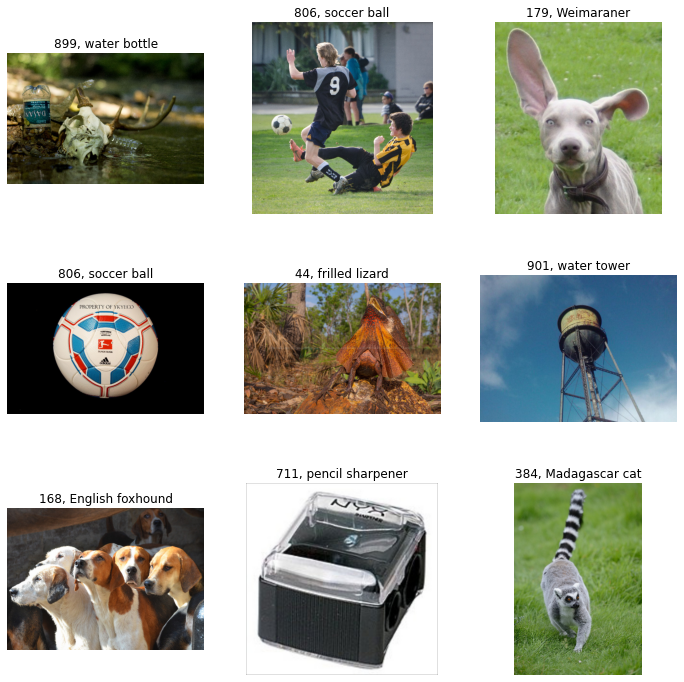

In [18]:
plt.figure(figsize=(12, 12))

for i in range(9):
  # 이미지를 랜덤으로 추출
  image_path = random.choice(all_image_paths)

  # 차례대로 출력
  plt.subplot(3, 3, i+1)

  # plt.show(): 이미지 출력
  # plt.imread(): 파일 읽어오기
  # 랜덤으로 선택된 사진 출력
  plt.imshow(plt.imread(image_path))

  # 첫 번째 부터 1000번째 까지의 라벨과 텍스트가 동일한 값을 갖도록 코딩
  idx = int(image_path.split('/')[-2]) + 1

  # 각 사진마다 라벨링 번호 + 라벨 텍스트 출력
  plt.title(str(idx) + ', ' + label_text[idx]) 

  # 픽셀 크기를 나타내는 축 제거('off')
  plt.axis('off')

plt.show()

MovileNet 정확도 확인

- Top - 5 정확도: 전통적으로 ImageNet 대회에서는 신경망이 예측하는 값 중 상위 5개 이내에 데이터의 실제 분류가 포함돼 있으면 정답 인정

- Top - 1 정확도: 신경망이 예측하는 값 중 상위 1개 이내에 데이터의 실제 분류가 포함돼 있으면 정답으로 인정

- 최초의 MobileNetV 버전의 Top-5: 89.9% / Top-1: 70.9%

- Reference: https://github.com/tensorflow/models/blob/master/research/slim/nets/mobilenet_v1.md

In [19]:
import cv2
import numpy as np 

In [22]:
# 빈 객체 생성
top_1 = 0
top_5 = 0

# all_image_paths에 저장되어 있는 경로를 하나씩 불러오며 반복
for image_path in all_image_paths[0:100]:
  # 사진 읽어들이기
  img = cv2.imread(image_path)

  # 사진 크기 재조정(픽셀 통일)
  img = cv2.resize(img, dsize=(224, 224))

  # 최소 최대 정규화
  img = img / 255.0

  # 첫 번째 차원 추가 --> 채널 추가
  img = np.expand_dims(img, axis=0)

  # 예측값에 대한 순위 정보[0]를 argsort()로 index 정렬(오름차순)
  # [::-1] Extended Slices 기법으로 내림차순으로 변경, [:5] 그 중 top 5개
  top_5_predict = model.predict(img)[0].argsort()[::-1][:5]

  # 라벨링 번호 도출
  idx = int(image_path.split('/')[-2]) + 1

  # 신경망은 반복문을 타고 넘어온 n번째 img를 가지고 예측을 수행해서 5개의 TOP 후보(top_5_predict)를 추렸다.
  # 만약 이 n번째 img가 신경망이 가장 높게 예측한 후보 5개 안에 들어있다면은
  if idx in top_5_predict:
    # top_5에 1 추가
    top_5 += 1

    # 또 만약에 가장 높게 예측한 것[0]과 idx가 같다면
    if top_5_predict[0] == idx:
      # top_1에 1을 추가
      top_1 += 1


# 최종 출력
# 정확하게 예측한 경우 / 전체 사진수
print('TOP-5 정확성: ', top_5 / len(all_image_paths)*100, '%')
print('TOP-1 정확성: ', top_1 / len(all_image_paths)*100, '%')

TOP-5 정확성:  0.84 %
TOP-1 정확성:  0.63 %


- cv2.imread()

  - 사진 읽어들이기

- cv2.resize()
  
  - 사진 크기 재조정(픽셀 통일)

- np.expand_dims(axis=0)

  - 첫 번째 차원 추가 -> 채널 추가

MobileNet의 분류 및 실제 결과 확인

- softmax 개선식 활용

  - overflow 문제 해결

  - 0 나눗셉 문제 해결

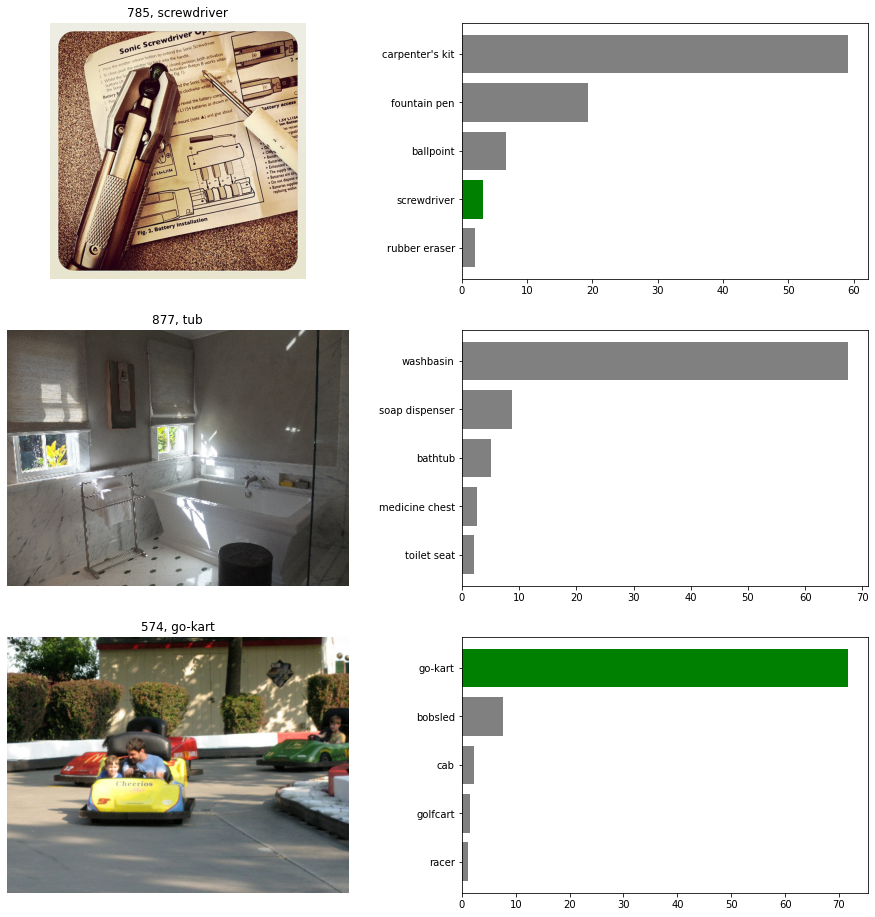

In [30]:
plt.figure(figsize=(16, 16))

# softmax 개선식 적용
def softmax(x):
  max_elem = np.max(x)
  diff = (x - max_elem)
  exp = np.exp(diff)
  sum_exp = np.sum(exp)
  probs = (exp / sum_exp)
  return probs


# 3개에 대한 결과 표시
for c in range(3):
  image_path = random.choice(all_image_paths)

  # 이미지 표시
  # plt.subplot(행, 열, (1, 3, 5))
  plt.subplot(3, 2, c*2+1)

  # 이미지 출력
  plt.imshow(plt.imread(image_path))

  # 이미지 번호 변수화
  idx = int(image_path.split('/')[-2]) + 1

  # 번호 + 라벨링 출력
  plt.title(str(idx) + ', ' + label_text[idx])

  plt.axis('off')

  # 예측값 표시
  plt.subplot(3, 2, c*2+2)

  # 이미지 읽기
  img = cv2.imread(image_path)

  # 이미지 크기 통일
  img = cv2.resize(img, dsize=(224, 224))

  # 이미지 정규화
  img = img / 255.0

  # 차원 추가
  img = np.expand_dims(img, axis=0)

  # MobileNet을 이용한 예측한 값을 logit값으로 저장
  logits = model.predict(img)[0]

  # softmax() 를 활용하여 예측 확률 출력
  prediction = softmax(logits)

  # 가장 높은 확률의 예측값 5개를 뽑음
  top_5_predict = prediction.argsort()[::-1][:5]

  # 신경망 예측 결과인 top_5_predict(숫자)를 가지고 라벨링 명으로 변환
  labels = [label_text[index] for index in top_5_predict]
  color = ['gray']*5

  # 만약 idx가 예측값안에 있다면
  if idx in top_5_predict:
    # top_5_predict를 tolist() 리스트화 시키고, 그 안에있는 idx를 인덱스화 시켜준다음 'x색'을 바꿔준다
    color[top_5_predict.tolist().index(idx)] = 'green'

  # Extended Slices으로 내림차순으로 변경 즉, 가자 ㅇ상단에 'x색'이 오도록
  color = color[::-1]

  # 가로 막대 그리기
  plt.barh(range(5), prediction[top_5_predict][::-1]*100, color=color)

  # y축의 '틱' 정보 표시
  plt.yticks(range(5), labels[::-1])